請選擇1檔有發行美國存託憑證（ADR）的台股， 計算該標的與該標的ADR價格的相關係數， 並以該標的ADR價格為自變數工該標的價 格為應鑾數進行迴歸式估計

以台積電為例。

In [100]:
from requests import Session
from requests_cache import CacheMixin, SQLiteCache
from requests_ratelimiter import LimiterMixin, MemoryQueueBucket
from pyrate_limiter import Duration, RequestRate, Limiter
class CachedLimiterSession(CacheMixin, LimiterMixin, Session):
    pass

session = CachedLimiterSession(
    limiter=Limiter(RequestRate(2, Duration.SECOND*5)),  # max 2 requests per 5 seconds
    bucket_class=MemoryQueueBucket,
    backend=SQLiteCache("yfinance.cache"),
)
session.headers['User-agent'] = 'n.finance/1.0'

In [101]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf

tickers = yf.Tickers(['2330.TW', 'TSM'], session=session)

In [102]:
# Get the close prices of 2330.TW
taiwan_price = tickers.tickers['2330.TW'].history(period='max', auto_adjust=False)
usa_price = tickers.tickers['TSM'].history(period='max', auto_adjust=False)

# Get the cumulative return
taiwan_return = taiwan_price['Close'].pct_change().cumsum()
usa_return = usa_price['Close'].pct_change().cumsum()

# Reduce the time series to day
taiwan_return.index = taiwan_return.index.date  # type: ignore
usa_return.index = usa_return.index.date  # type: ignore

# Concatinate the return
df = pd.concat([taiwan_return, usa_return], axis=1, keys=['taiwan', 'usa']).dropna()

In [103]:
df

,taiwan,usa
2000-01-05,0.022470,1.527564
2000-01-06,0.000494,1.485898
2000-01-07,-0.027598,1.523941
2000-01-10,0.007084,1.564517
2000-01-11,-0.009675,1.550681
...,...,...
2023-11-27,3.238986,5.218603
2023-11-28,3.251310,5.226524
2023-11-29,3.249571,5.235709
2023-11-30,3.254797,5.219831


In [104]:
# Calculate the OLS Regression of the cumulative return
import statsmodels.api as sm

X = sm.add_constant(df["usa"])
model = sm.OLS(df["taiwan"], X)
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 taiwan   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.646e+06
Date:                Mon, 04 Dec 2023   Prob (F-statistic):               0.00
Time:                        14:29:55   Log-Likelihood:                 7521.5
No. Observations:                5764   AIC:                        -1.504e+04
Df Residuals:                    5762   BIC:                        -1.503e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.4644      0.002   -660.383      0.000      -1.469      -1.460
usa            0.8973      0.001   1283.049      0.000       0.896       0.899
==============================================================================
Omnibus:                       76.320   Durbin-Watson:                   0.139
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.937
Skew:                          -0.168   Prob(JB):                     9.66e-14
Kurtosis:                       2.631   Cond. No.                         8.83
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: title={'center': 'Cumulative Return of Taiwan and USA'}, xlabel='Date', ylabel='Cumulative Return'>

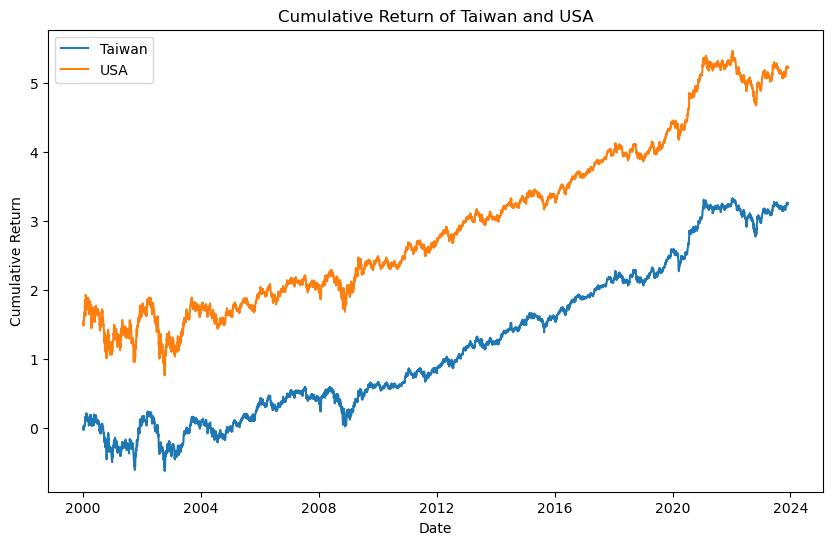

In [105]:
plot = df.plot(figsize=(10, 6))
plot.set_xlabel("Date")
plot.set_ylabel("Cumulative Return")
plot.set_title("Cumulative Return of Taiwan and USA")
plot.legend(["Taiwan", "USA"])
plot